In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wm811k-wafer-map/LSWMD.pkl


In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

['wm811k-wafer-map']


In [35]:
import pandas as pd


file_path = '/kaggle/input/wm811k-wafer-map/LSWMD.pkl'
df_init = pd.read_pickle(file_path)
df_init.info()
#}

#If dataframe is saved locally:
#import pandas as pd
#df = pd.read_pickle("./data/LSWMD.pkl")
#df.info()

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random

# display dataframe format and categories
df_init.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [36]:
df = df_init.copy()
df = df.drop(['waferIndex'], axis = 1)
df = df.drop(['lotName'], axis = 1)
df = df.drop(['dieSize'], axis = 1)
df = df.drop(['trianTestLabel'], axis = 1)
df.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]


In [37]:

df2 = df.copy()
df2.failureType = df2.failureType.apply(lambda x: x[0][0] if len(x) > 0 else float("NaN"))
df2['failureType'] = df2['failureType'].astype('category')

# Check falure type distribution
# Check failure type distribution of wafers with non-null labels

df2['failureType'].value_counts()
#df2['failureType'].value_counts(dropna = False, normalize = True).plot.pie()
#df2['failureType'].value_counts().plot.bar()
#df2['failureType'].value_counts().sum()
# There are 172950 (sum)
# df2.shape[0] -> 811457

failureType
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64

In [38]:
df2['failureNum'] = df2.failureType
mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

df2 = df2.replace({'failureNum':mapping_type}).infer_objects(copy=False)
df2['failureNum'] = pd.to_numeric(df2['failureNum'], errors='coerce')

df2 = df2[(df2['failureNum']>=0) & (df2['failureNum']<=8)]

# removes 149 occasions. shown above ^
#df2 = df2[(df2['failureType']!='Near-full')]

df2['failureType'] = df2['failureType'].cat.remove_unused_categories()

# Filter out filter maps that are too small
# size_filter = [all(np.greater(df2['waferMapDim'].iloc[i], (5,5))) for i in range(len(df2))]
# df2 = df2[size_filter]
df2.shape[0]


172950

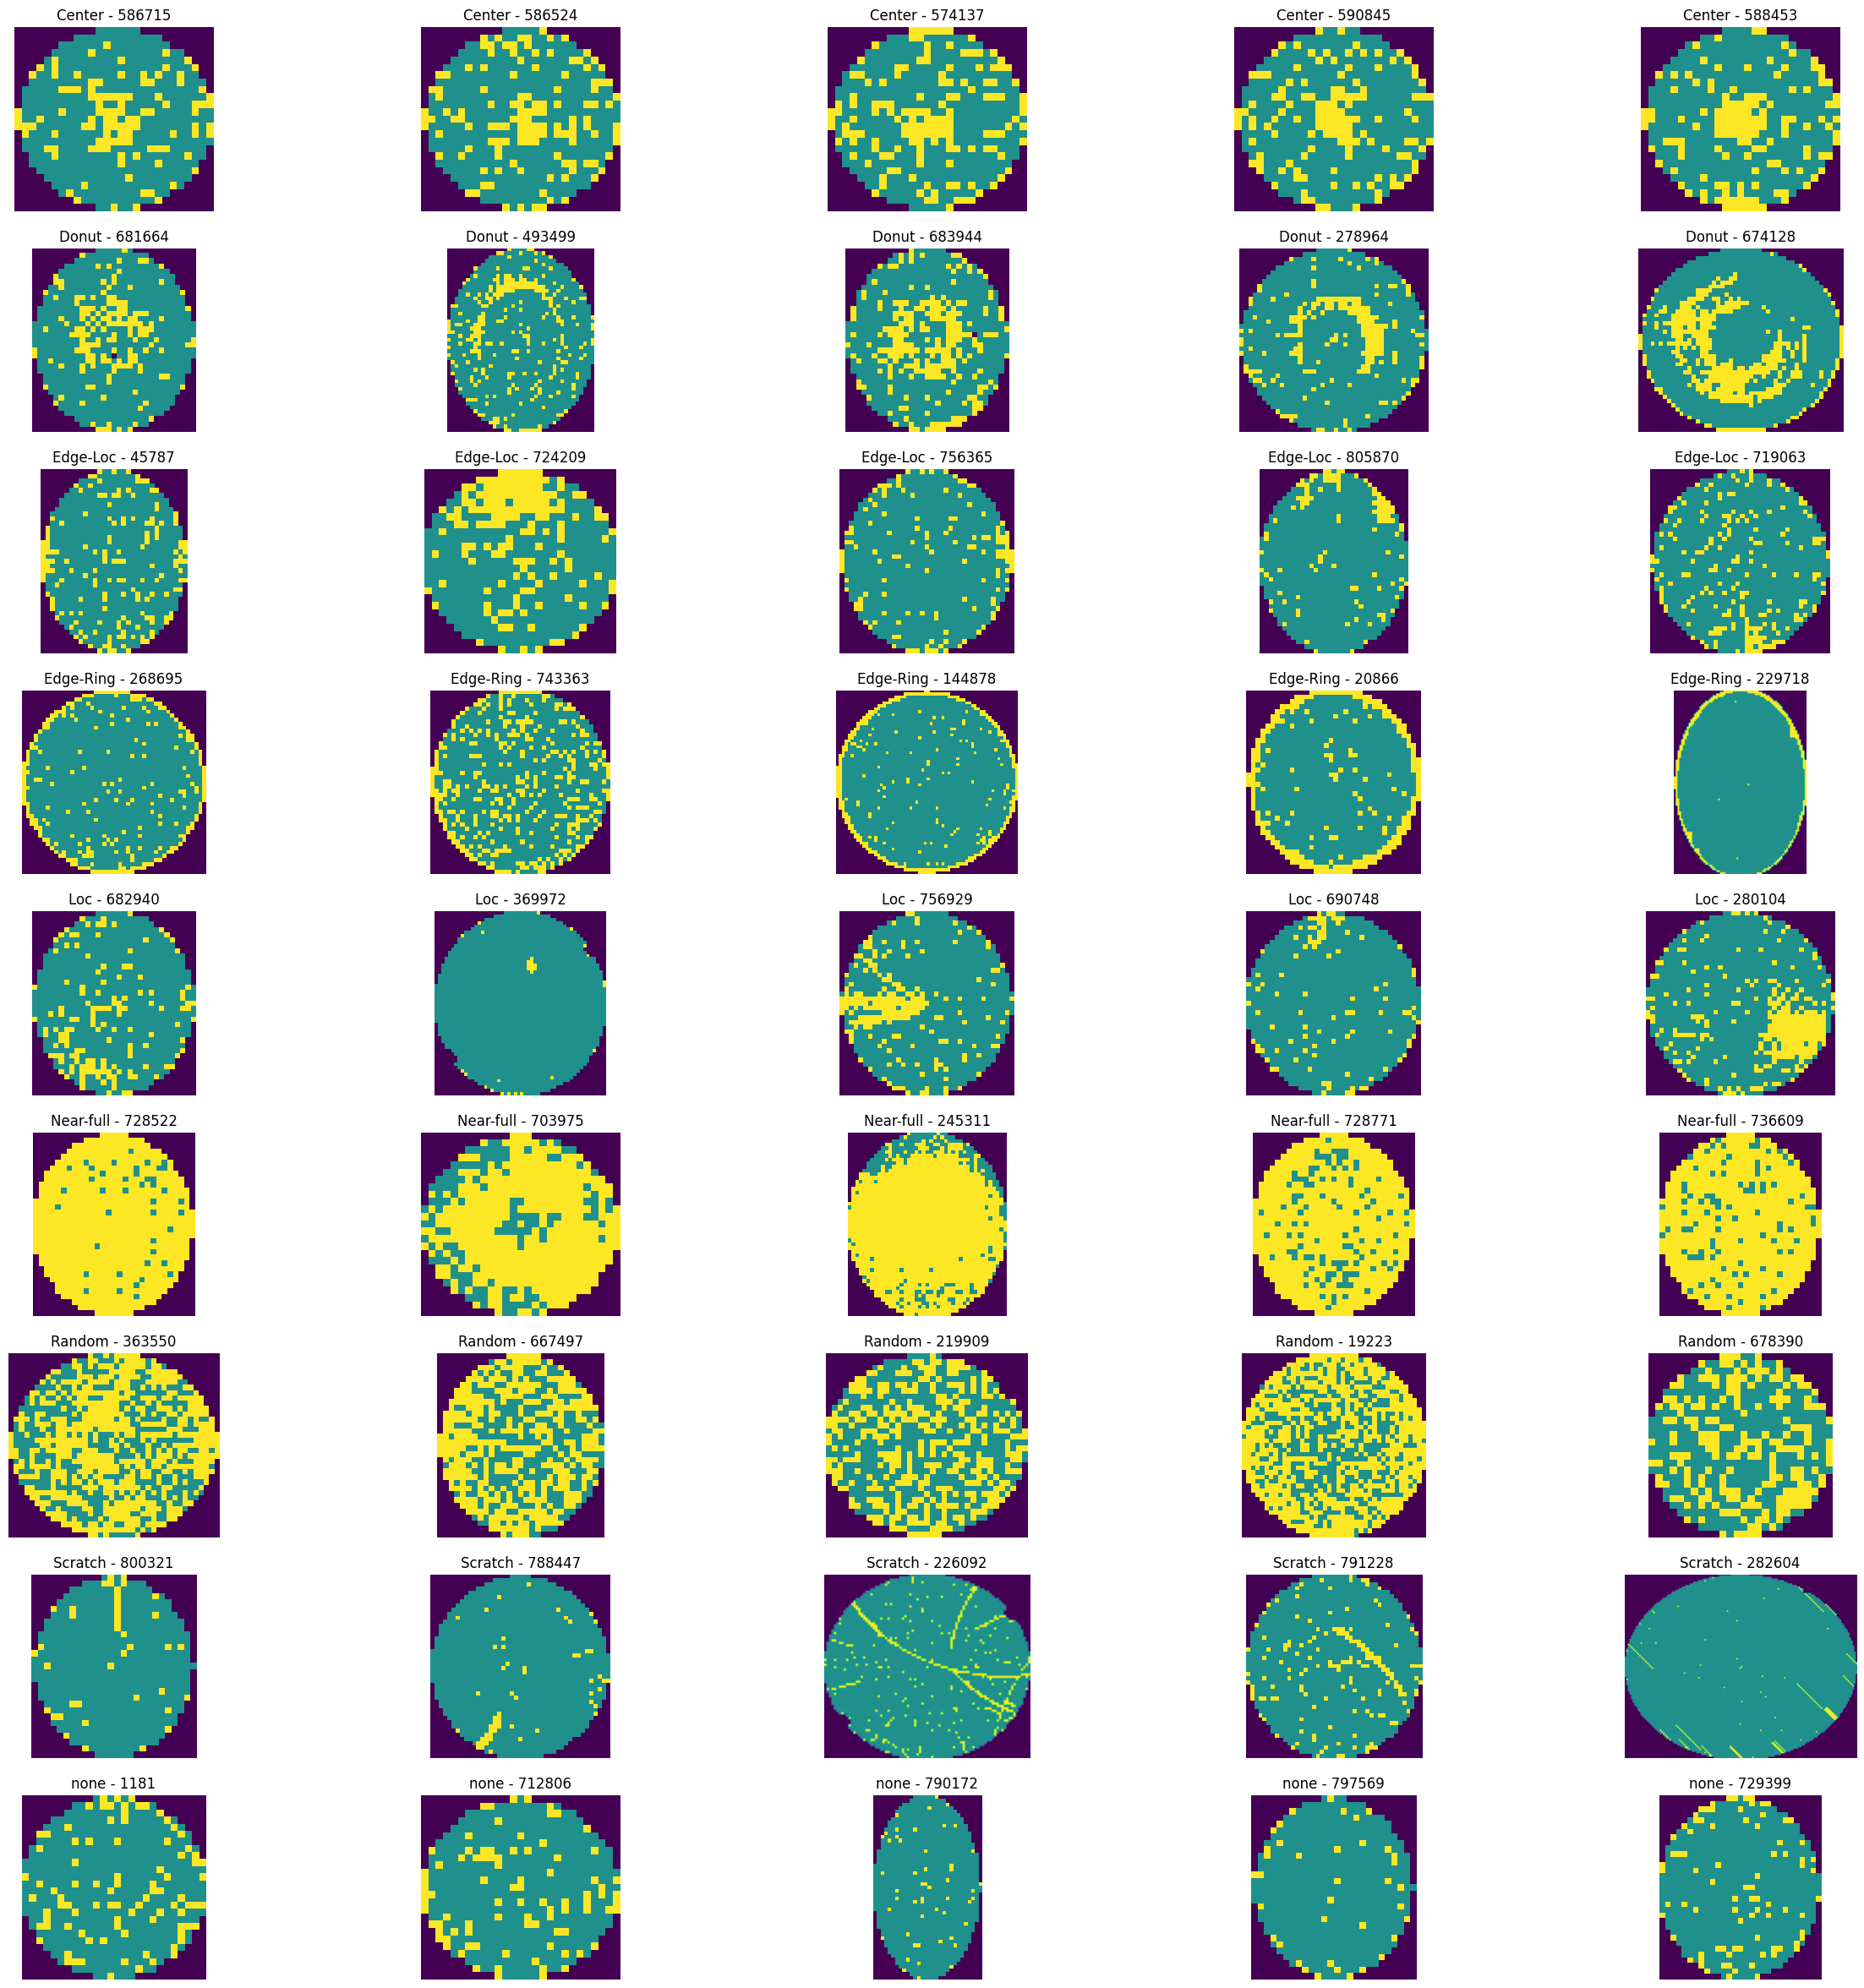

In [39]:
sample_size = 5
failure_types = list(df2['failureType'].cat.categories)
num_cat = len(failure_types)
fig, axs = plt.subplots(num_cat, sample_size, figsize = (30,30))
for i_cat in range(num_cat):
    cat = failure_types[i_cat]
    random.seed(10)
    sample = df2.loc[df2['failureType'] == cat].sample(sample_size)
    for i in range(len(sample)):
        index = sample.index[i]
        axs[i_cat, i].axis('off')
        axs[i_cat, i].imshow(sample['waferMap'][index])
        axs[i_cat, i].set_title(f'{cat} - {index}')

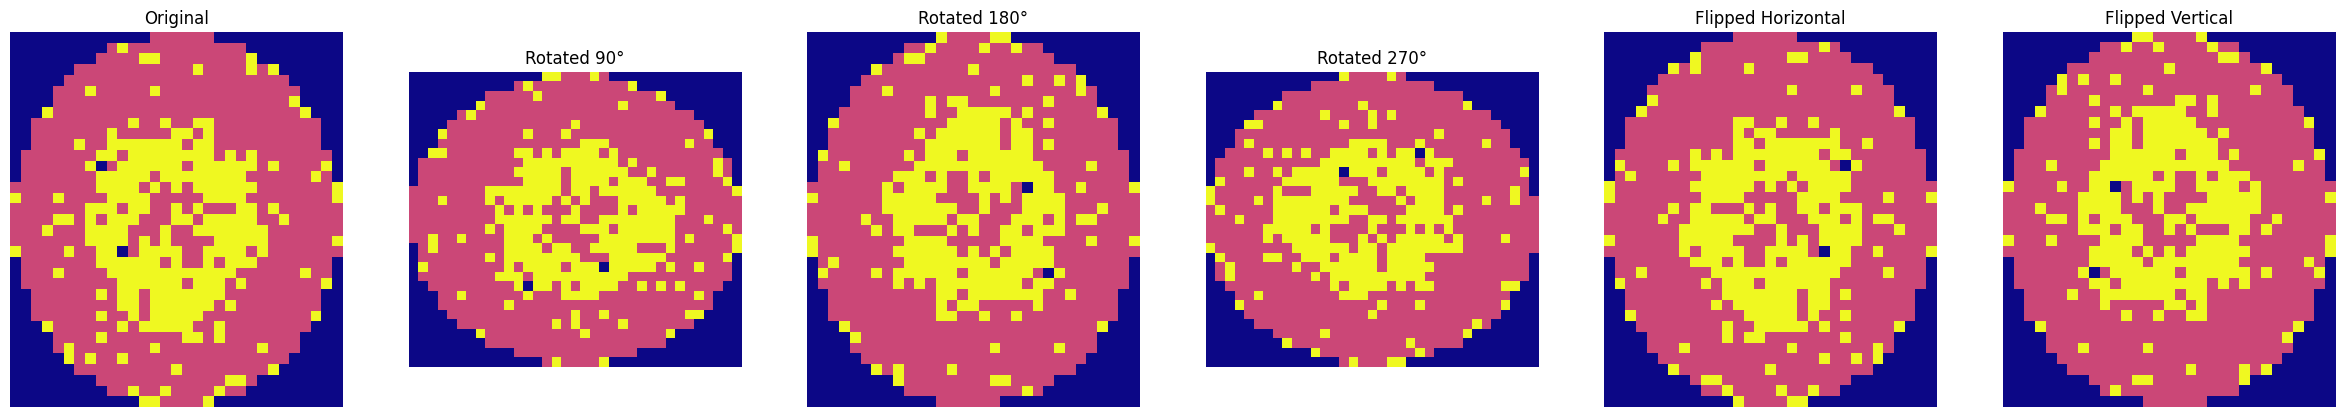

failureType
none         147431
Edge-Ring     58080
Edge-Loc      31134
Center        25764
Loc           21558
Scratch        7158
Random         5196
Donut          3330
Near-full       894
Name: count, dtype: int64


In [40]:
import random

df3 = df2.copy()

def oversample(df):
    # Create an empty list to store the augmented data
    augmented_data = []
    valid_df = df[df['failureType'] != 'none']
    sample = random.choice(valid_df.index)

    for index, row in valid_df.iterrows():
        wafer_map = row['waferMap']
        rotated_90 = np.rot90(wafer_map)
        rotated_180 = np.rot90(wafer_map, 2)
        rotated_270 = np.rot90(wafer_map, 3)
        flipped_horizontal = np.fliplr(wafer_map)
        flipped_vertical = np.flipud(wafer_map)

        augmented_data.append({'waferMap': rotated_90, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': rotated_180, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': rotated_270, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': flipped_horizontal, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': flipped_vertical, 'failureType': row['failureType'], 'failureNum': row['failureNum']})

        if index==sample:
            fig, axs = plt.subplots(1, 6, figsize=(30,30))
            axs[0].imshow(wafer_map, cmap='plasma')
            axs[0].set_title("Original")
            axs[1].imshow(rotated_90, cmap='plasma')
            axs[1].set_title("Rotated 90°")
            axs[2].imshow(rotated_180, cmap='plasma')
            axs[2].set_title("Rotated 180°")
            axs[3].imshow(rotated_270, cmap='plasma')
            axs[3].set_title("Rotated 270°")
            axs[4].imshow(flipped_horizontal, cmap='plasma')
            axs[4].set_title("Flipped Horizontal")
            axs[5].imshow(flipped_vertical, cmap='plasma')
            axs[5].set_title("Flipped Vertical")
            for ax in axs:
                ax.axis('off')
            plt.show()

    # Add augmented sample to original df
    augmented_df = pd.DataFrame(augmented_data)
    oversampled_df = pd.concat([df, augmented_df], ignore_index=True)

    return oversampled_df

df3 = oversample(df3)
print(df3.failureType.value_counts())


In [41]:
from sklearn.model_selection import train_test_split

X = df3['waferMap'].values
y = df3['failureNum'].values

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({8.0: 110497, 3.0: 43488, 2.0: 23384, 0.0: 19343, 4.0: 16210, 6.0: 5415, 5.0: 3920, 1.0: 2492, 7.0: 659})
Testing target statistics: Counter({8.0: 36934, 3.0: 14592, 2.0: 7750, 0.0: 6421, 4.0: 5348, 6.0: 1743, 5.0: 1276, 1.0: 838, 7.0: 235})


In [42]:
import cv2
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (48, 48))
        resized_images.append(resized_image)
    return np.array(resized_images)

X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape and number of classes
num_classes = 9  # Replace with the actual number of classes

# Build the model
model = models.Sequential([
    # Input layer with normalization
    layers.Rescaling(1/2, input_shape=(48, 48, 1)),  # Normalization from 0 to 2

    # First convolutional block
    layers.Conv2D(8, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Second convolutional block
    layers.Conv2D(16, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Third convolutional block
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Fourth convolutional block
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),

    # Dropout layer
    layers.Dropout(0.5),  # Adjust dropout rate if needed

    # Fully connected layer
    layers.Flatten(),
    layers.Dense(num_classes),
    layers.Softmax()
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │        20,745 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,609 (178.16 KB)

 Trainable params: 45,369 (177.22 KB)

 Non-trainable params: 240 (960.00 B)

In [44]:
#import tensorflow as tf

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#model.compile(optimizer=optimizer,
 #             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  #            metrics=['accuracy'])

#X_train_resized = X_train_resized.astype('float32') / 255.0
#X_test_resized = X_test_resized.astype('float32') / 255.0

#train_ds = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train)).batch(64).shuffle(1000).prefetch(tf.data.AUTOTUNE)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test)).batch(64)

#history = model.fit(train_ds, epochs=10, validation_data=test_ds, verbose=1)


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 9

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,305 (3.20 MB)

 Trainable params: 839,305 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
import numpy as np
import tensorflow as tf

# --- Preprocessing Fix ---

# If images are grayscale (48x48), add channel dimension
if X_train_resized.ndim == 3:
    X_train_resized = np.expand_dims(X_train_resized, axis=-1)
    X_test_resized = np.expand_dims(X_test_resized, axis=-1)

# If model expects 3 channels (RGB), repeat grayscale channels
expected_input_shape = model.input_shape[-1]
if expected_input_shape == 3 and X_train_resized.shape[-1] == 1:
    X_train_resized = np.repeat(X_train_resized, 3, axis=-1)
    X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Normalize pixel values
X_train_resized = X_train_resized.astype('float32') / 255.0
X_test_resized = X_test_resized.astype('float32') / 255.0

# --- Training Fix ---
history = model.fit(
    X_train_resized, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_resized, y_test),
    shuffle=True,
    verbose=1
)

# --- Evaluation ---
test_loss, test_acc = model.evaluate(X_test_resized, y_test, verbose=1)
print(f"\n Test Accuracy: {test_acc * 100:.2f}% | Test Loss: {test_loss:.4f}")


Epoch 1/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 294s 166ms/step - accuracy: 0.6104 - loss: 1.1881 - val_accuracy: 0.8058 - val_loss: 0.6008
Epoch 2/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 291s 165ms/step - accuracy: 0.8066 - loss: 0.6026 - val_accuracy: 0.8351 - val_loss: 0.5261
Epoch 3/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 286s 162ms/step - accuracy: 0.8319 - loss: 0.5261 - val_accuracy: 0.8419 - val_loss: 0.4935
Epoch 4/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 278s 158ms/step - accuracy: 0.8535 - loss: 0.4544 - val_accuracy: 0.8663 - val_loss: 0.4007
Epoch 5/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 295s 167ms/step - accuracy: 0.8736 - loss: 0.3854 - val_accuracy: 0.8842 - val_loss: 0.3442
Epoch 6/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 286s 163ms/step - accuracy: 0.8869 - loss: 0.3407 - val_accuracy: 0.8981 - val_loss: 0.2988
Epoch 7/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 294s 167ms/step - accuracy: 0.8967 - loss: 0.3056 - val_accuracy: 0.9035 - val_loss: 0.2775
Epoch 8/30
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 286s 162ms/step - ac

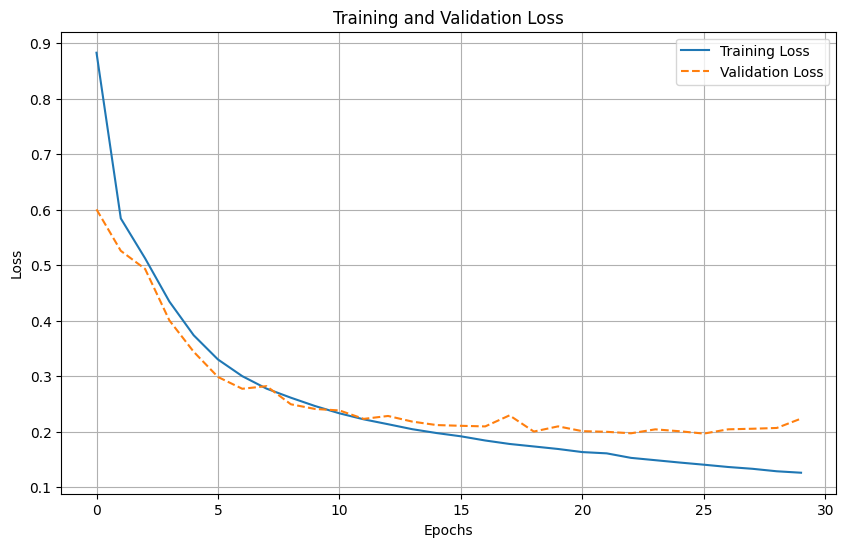

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

2349/2349 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step


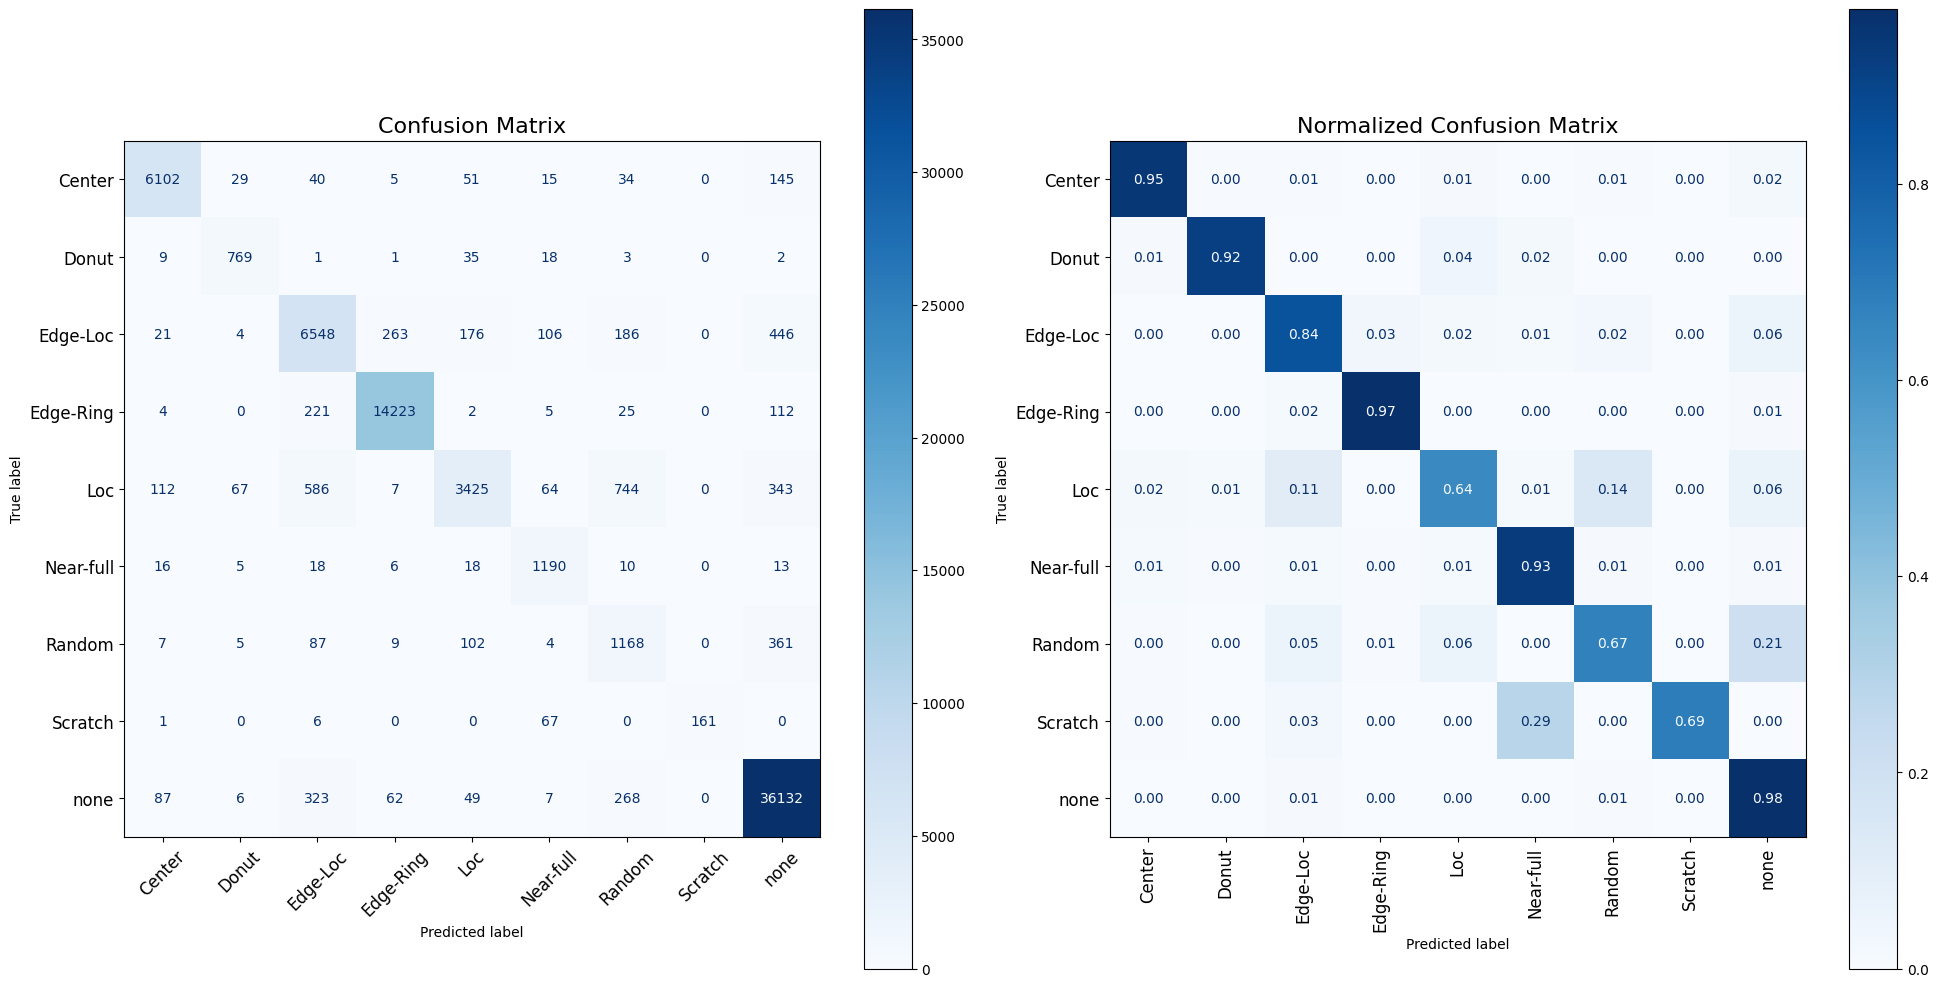

In [60]:
import numpy as np

# Force test data to grayscale (1 channel)
if X_test_resized.shape[-1] == 3:
    print("Converting X_test_resized from RGB (3 channels) → Grayscale (1 channel)")
    X_test_resized = X_test_resized[..., 0:1]  # Take only one channel

elif X_test_resized.ndim == 3:  # shape = (n, 48, 48)
    print("Adding channel dimension for grayscale input")
    X_test_resized = np.expand_dims(X_test_resized, axis=-1)

# Predict
y_pred = np.argmax(model.predict(X_test_resized), axis=1)

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Standard Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=failure_types)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=16)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=failure_types)
disp_normalized.plot(include_values=True, cmap=plt.cm.Blues, values_format='.2f', ax=axes[1], xticks_rotation='vertical')
axes[1].set_title('Normalized Confusion Matrix', fontsize=16)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step


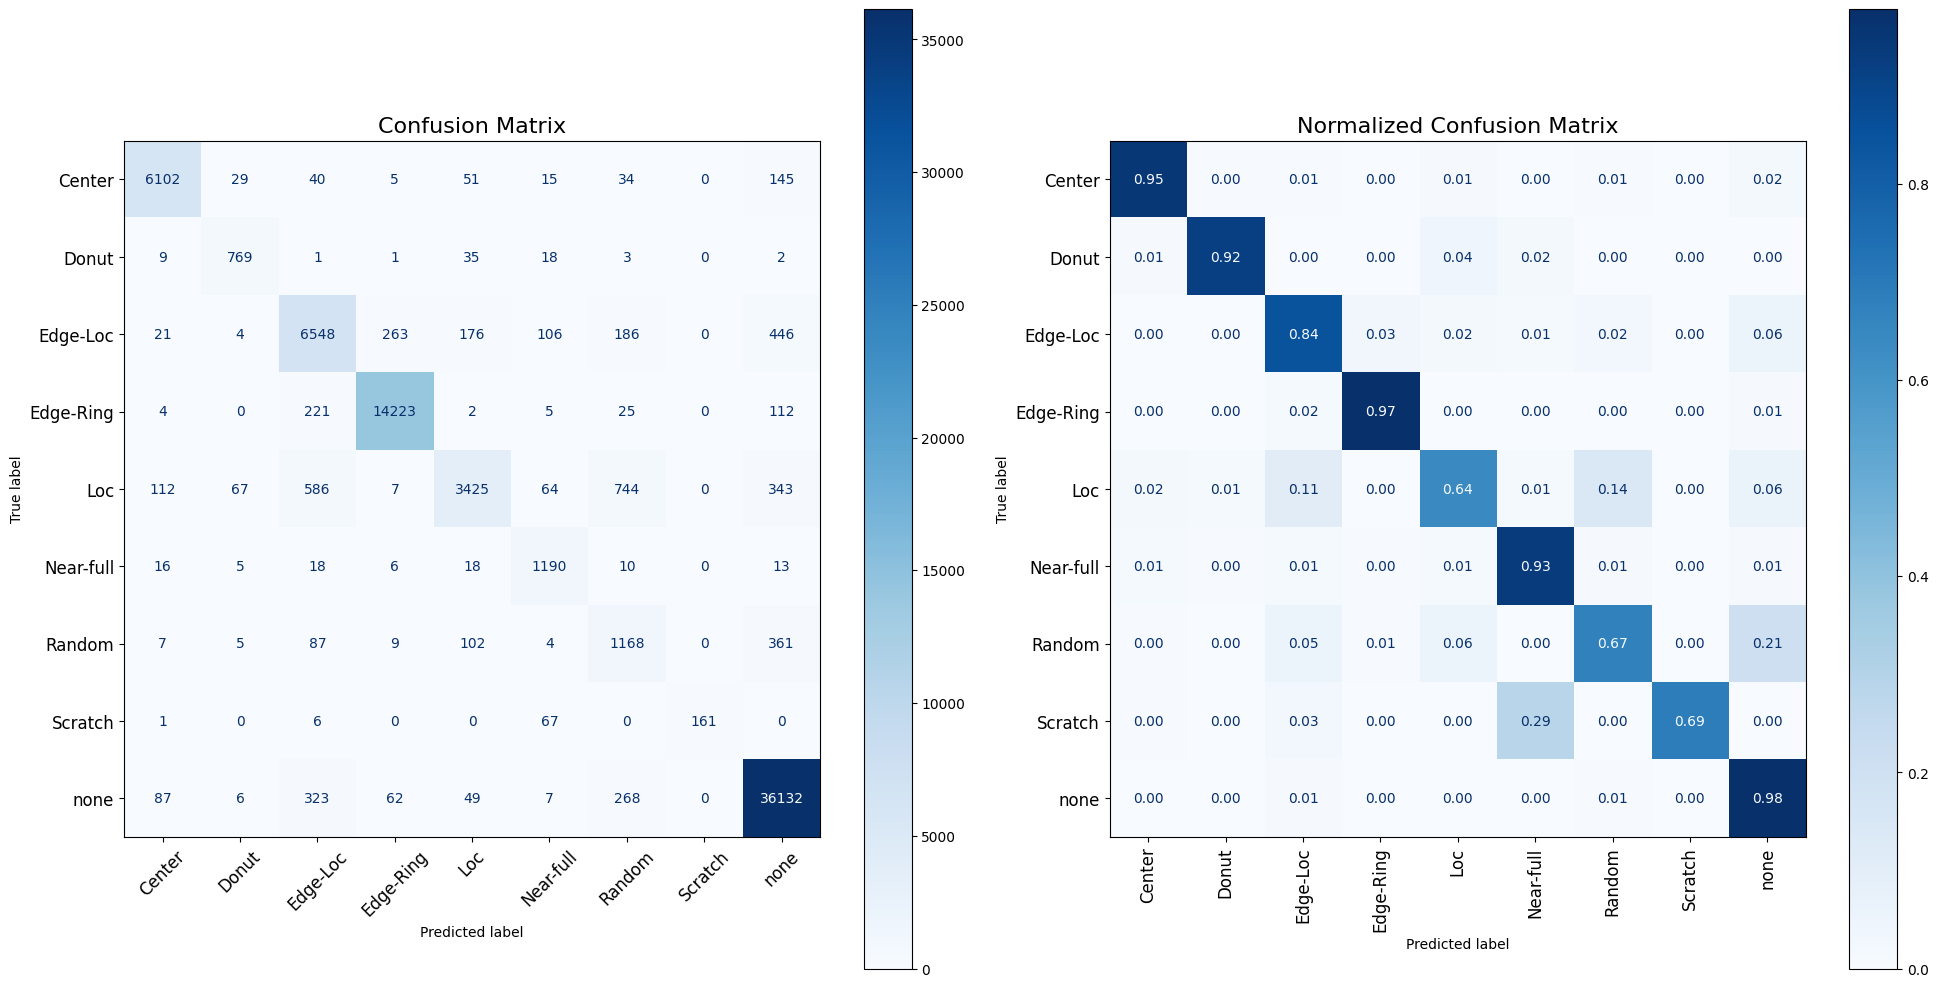

In [61]:
y_pred = np.argmax(model.predict(X_test_resized), axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot the standard confusion matrix on the first subplot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=failure_types)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[0])  # Plot on the first subplot (axes[0])
axes[0].set_title('Confusion Matrix', fontsize=16)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the normalized confusion matrix on the second subplot
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=failure_types)
disp_normalized.plot(include_values=True, cmap=plt.cm.Blues, values_format='.2f', ax=axes[1], xticks_rotation='vertical')  # Plot on the second subplot (axes[1])
axes[1].set_title('Normalized Confusion Matrix', fontsize=16)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [62]:
import pandas as pd

# Initialize parameters
pr_table = pd.DataFrame(index=failure_types, columns=["Recall", "Precision", "F1"])

# Calculate Precision, Recall, and F1 score for each class
for idx in range(num_classes):
    # True Positives (TP), False Positives (FP), and False Negatives (FN)
    num_tp = cm[idx, idx]
    num_fp = sum(cm[:, idx]) - num_tp
    num_fn = sum(cm[idx, :]) - num_tp

    # Calculate precision and recall, handling division by zero
    precision = num_tp / (num_tp + num_fp) if (num_tp + num_fp) > 0 else 0.0
    recall = num_tp / (num_tp + num_fn) if (num_tp + num_fn) > 0 else 0.0

    # Calculate F1 score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Store the values in the table
    pr_table.loc[failure_types[idx], "Recall"] = recall
    pr_table.loc[failure_types[idx], "Precision"] = precision
    pr_table.loc[failure_types[idx], "F1"] = f1_score

# Display the Precision-Recall table
print(pr_table)

             Recall Precision        F1
Center     0.950319  0.959585   0.95493
Donut      0.917661  0.868927  0.892629
Edge-Loc   0.844903  0.836271  0.840565
Edge-Ring  0.974712  0.975782  0.975247
Loc        0.640426  0.887766   0.74408
Near-full  0.932602  0.806233  0.864826
Random     0.670109  0.479081  0.558718
Scratch    0.685106       1.0  0.813131
none       0.978286  0.962135  0.970143


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step


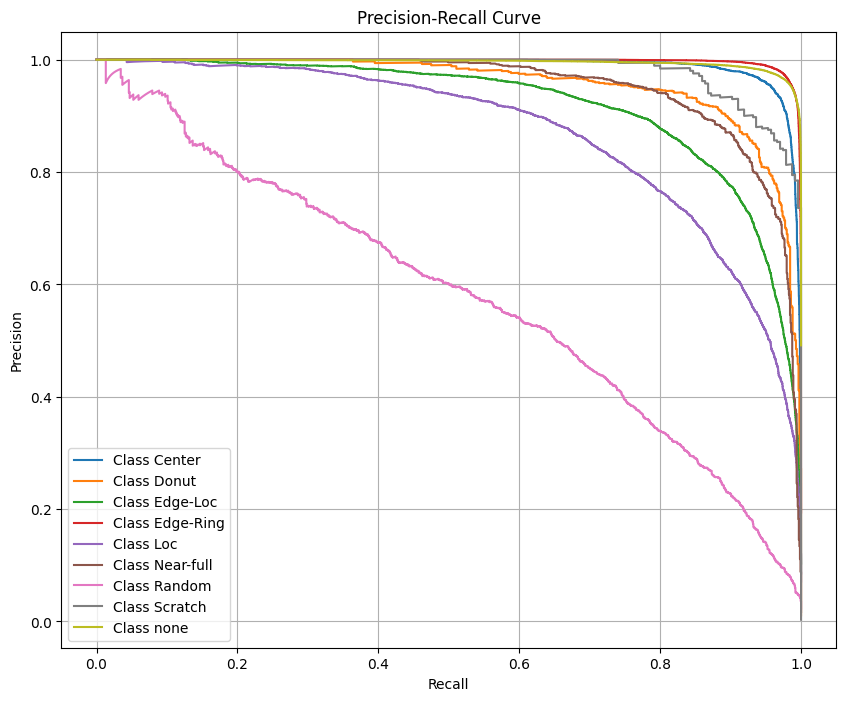

In [63]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Predict probabilities for each class
y_score = model.predict(X_test_resized)

# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {failure_types[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

2349/2349 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9276 - loss: 0.2252

Test Accuracy: 92.79%
Test Loss: 0.2238
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step

 Classification Report:
              precision    recall  f1-score   support

      Center       0.96      0.95      0.95      6421
       Donut       0.87      0.92      0.89       838
    Edge-Loc       0.84      0.84      0.84      7750
   Edge-Ring       0.98      0.97      0.98     14592
         Loc       0.89      0.64      0.74      5348
   Near-full       0.81      0.93      0.86      1276
      Random       0.48      0.67      0.56      1743
     Scratch       1.00      0.69      0.81       235
        none       0.96      0.98      0.97     36934

    accuracy                           0.93     75137
   macro avg       0.86      0.84      0.85     75137
weighted avg       0.93      0.93      0.93     75137



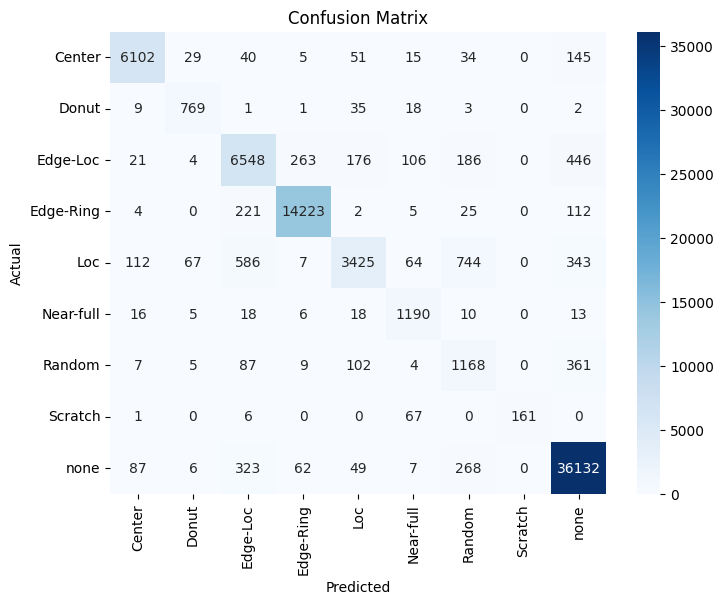

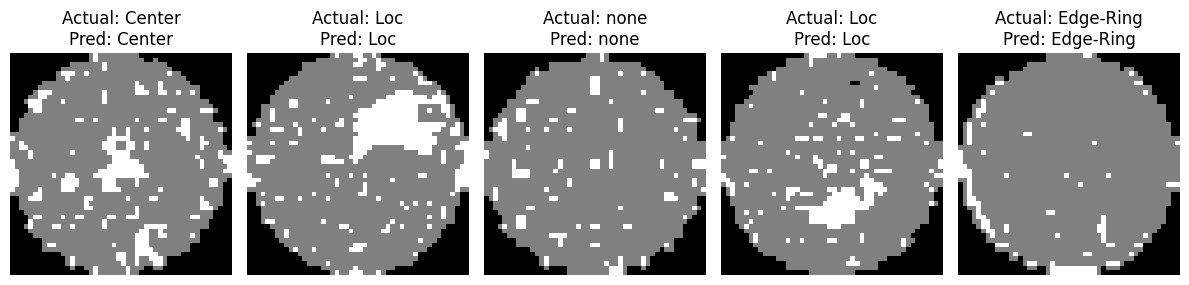

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure correct dtype and shape
X_test_resized = np.array(X_test_resized).astype("float32")
y_test = np.array(y_test).astype("int64")

# Evaluate model performance
test_loss, test_acc = model.evaluate(X_test_resized, y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = np.argmax(model.predict(X_test_resized), axis=1)
y_true = y_test  # Already integer labels

# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=failure_types))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=failure_types, yticklabels=failure_types)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Show sample predictions
num_samples = 5
indices = np.random.choice(len(X_test_resized), num_samples, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i+1)
    image = X_test_resized[idx].squeeze()  # Remove extra dimension
    plt.imshow(image, cmap='gray')
    plt.title(f"Actual: {failure_types[y_true[idx]]}\nPred: {failure_types[y_pred[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
